In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, classification_report
from matplotlib import pyplot as plt

/usr/local/lib/python3.8/dist-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### 1 Load and prepare CEO data

In [2]:
# read csv file
ceo = pd.read_csv('/home/sepal-user/sbae_point_analysis_CIV/erp_1km/ign_ERP_CIV_692pts_20221026.csv', delimiter=',')
print(ceo.columns)
ceo.head(1)

Index(['X', 'Y', 'PLOTID', 'LON', 'LAT', 'strate', 'prob_chang', 'ID',
       'INT1_2000', 'INT1_2010', 'INT1_2015', 'INT1_2020', 'INT1_2021',
       'CHG_20_21', 'CHG_00_10', 'CHG_10_15', 'CHG_15_20', 'IC', 'COMMENT.',
       'P-I_name'],
      dtype='object')


,X,Y,PLOTID,LON,LAT,strate,prob_chang,ID,INT1_2000,INT1_2010,INT1_2015,INT1_2020,INT1_2021,CHG_20_21,CHG_00_10,CHG_10_15,CHG_15_20,IC,COMMENT.,P-I_name
0,49534.66052,568818.388616,63667,-7.061038,5.133202,3,0.523027,346,21,21,21,21,21,Stable,Stable,Stable,Stable,1,NaN,AMO


In [5]:
# subset columns
ceo = ceoIC[['PLOTID', 'LON', 'LAT', 'CHG_00_10', 'CHG_10_15']]

# add CNC column for classification
ceo['cnc_0010'] = ceo['CHG_00_10'].apply(lambda x: 1 if x == 'Deforestation' else 0)
ceo['cnc_1015'] = ceo['CHG_10_15'].apply(lambda x: 1 if x == 'Deforestation' else 0)
ceo['cnc']      = ceo['cnc_0010'] + ceo['cnc_1015']

ceo.head(5)
np.unique(ceo['cnc'], return_counts=True)

/tmp/ipykernel_1385/64485306.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ceo['cnc_0010'] = ceo['CHG_00_10'].apply(lambda x: 1 if x == 'Deforestation' else 0)
/tmp/ipykernel_1385/64485306.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ceo['cnc_1015'] = ceo['CHG_10_15'].apply(lambda x: 1 if x == 'Deforestation' else 0)
/tmp/ipykernel_1385/64485306.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

(array([0, 1]), array([498,  63]))

### 2 Load and Prepare TS data

In [12]:
# load data
ts = pd.read_pickle('/home/sepal-user/sbae_point_analysis_CIV/erp_1km/erp_bdd_ts_aux_1km.pickle')

In [13]:
ts[['dates', 'ts', 'images']].head(5)
len(ts)

46415

In [14]:
# turn nan to 0
ts['gfc_lossyear'] = np.nan_to_num(ts['gfc_lossyear'])
# create a binary loss
ts['gfc_loss_binary'] = ts['gfc_lossyear'].apply(lambda x: 0 if x == 0 or x > 15 else 1)

In [15]:
# create a binary deforestation
ts['tmf_def_binary'] = ts['tmf_defyear'].apply(lambda x: 1 if x > 1999 and x <= 2015 else 0)

# create a binary degradation
ts['tmf_deg_binary'] = ts['tmf_degyear'].apply(lambda x: 1 if x > 1999 and x <= 2015 else 0)

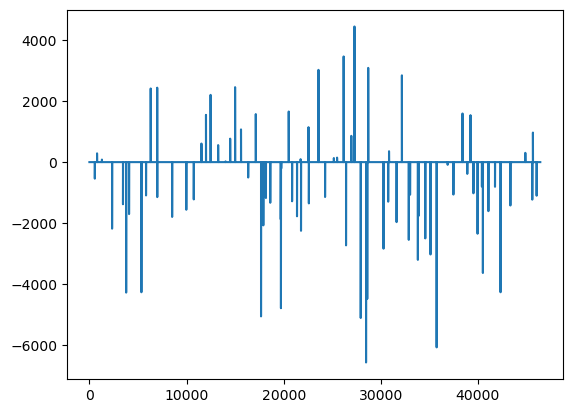

In [16]:
ts['ltr_magnitude'].plot()

### 2.1 Select columns for classification

In [17]:
cols_to_classify = [
    'images', 'mon_images',
    'gfc_tc00', 
    'gfc_loss_binary',
    'tmf_2000', 
    'tmf_def_binary', 'tmf_deg_binary',
    'bfast_magnitude',
    'ccdc_magnitude', 
    'ltr_magnitude', 'ltr_dur', 'ltr_rate',
    'cusum_confidence', 'cusum_magnitude', 
    'ts_mean', 'ts_sd', # we add this anyway in the next cell
    'ts_min', 'ts_max',
    'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max', 'bs_slope_min'
]


### 2.2 Extract time-series statistics for each band and add to predicitive data columns

In [18]:
bands = list(ts['ts'][1].keys())
print(' Bands available in dataset time-series: ')
print(bands) 
for band in bands:
    
    # add mean and SD value of time-series for each band
    ts[band + '_mean'] = ts['ts'].apply(lambda x: np.nanmean(np.array(x[band])))
    ts[band + '_sd'] = ts['ts'].apply(lambda x: np.nanstd(np.array(x[band])))
    
    # append to classification bands
    cols_to_classify.append(band + '_mean')
    cols_to_classify.append(band + '_sd')

 Bands available in dataset time-series: 
['green', 'red', 'nir', 'swir1', 'swir2', 'ndfi']


In [19]:
cols_to_classify

['images',
 'mon_images',
 'gfc_tc00',
 'gfc_loss_binary',
 'tmf_2000',
 'tmf_def_binary',
 'tmf_deg_binary',
 'bfast_magnitude',
 'ccdc_magnitude',
 'ltr_magnitude',
 'ltr_dur',
 'ltr_rate',
 'cusum_confidence',
 'cusum_magnitude',
 'ts_mean',
 'ts_sd',
 'ts_min',
 'ts_max',
 'bs_slope_mean',
 'bs_slope_sd',
 'bs_slope_max',
 'bs_slope_min',
 'green_mean',
 'green_sd',
 'red_mean',
 'red_sd',
 'nir_mean',
 'nir_sd',
 'swir1_mean',
 'swir1_sd',
 'swir2_mean',
 'swir2_sd',
 'ndfi_mean',
 'ndfi_sd']

In [20]:
print(' Number of predictive features: ' + str(len(cols_to_classify)))

 Number of predictive features: 34


### 2.3 Add a Kmeans column (because we can)

In [21]:
nr_of_cluster=50

# run kmeans
kmeans_model = KMeans(n_clusters=nr_of_cluster, random_state=42).fit(ts[cols_to_classify])
ts['kmeans'] = kmeans_model.predict(ts[cols_to_classify])

cols_to_classify.append('kmeans')

### 3 Merge CEO and TS data

In [22]:
df_class = pd.merge(ceo, ts[cols_to_classify + ['PLOTID']], how='inner', left_on='PLOTID', right_on='PLOTID')

### 4 Classification - Ensemble model creation

### 4.1 Train-Test Split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df_class[cols_to_classify + ['PLOTID']], df_class['cnc'], test_size=0.2, random_state=42, stratify=df_class['cnc'])

In [24]:
X_train
len(X_train)

448

In [25]:
X_test
len(X_test)
X_test.head()

,images,mon_images,gfc_tc00,gfc_loss_binary,tmf_2000,tmf_def_binary,tmf_deg_binary,bfast_magnitude,ccdc_magnitude,ltr_magnitude,...,nir_mean,nir_sd,swir1_mean,swir1_sd,swir2_mean,swir2_sd,ndfi_mean,ndfi_sd,kmeans,PLOTID
92,49,46,54,0,1,1,0,0.00000,0.0,0.0,...,3446.056738,857.731390,2166.726950,856.979186,1170.991135,793.083102,7757.767730,2280.540271,2,94399
369,60,58,62,1,1,1,0,0.00000,0.0,0.0,...,3197.525424,653.084207,1774.350282,465.871535,811.463277,300.761602,8823.799435,1346.162582,3,35769
20,64,59,0,0,5,0,0,2226.50708,0.0,0.0,...,1021.469355,561.829972,670.029301,477.439505,421.398925,315.399122,9529.080645,1290.192501,1,66976
420,46,42,72,0,1,0,0,0.00000,0.0,0.0,...,2848.041111,762.446245,1730.395926,592.583063,888.269259,441.772405,8249.948519,1973.467499,36,45035
214,69,66,76,1,1,0,1,0.00000,0.0,0.0,...,3215.499005,601.921027,1692.255224,376.495585,756.442537,267.683579,9417.049502,855.337999,12,29699


### 4.2 RF classification with automated model optimization for avoiding false positives in the stable class 

In [26]:
clf = RandomForestClassifier(n_jobs=-1, oob_score=True)

param_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [125, 250, 500],
    #'max_depth': [3, 5, 15, 25],
    'max_features': [5, 10, 20]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}


def grid_search_wrapper(refit_score='recall_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    
    skf = StratifiedKFold(n_splits=5)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score, cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train[cols_to_classify], y_train)

    # make the predictions
    y_pred = grid_search.predict(X_test[cols_to_classify])

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

grid_search_clf = grid_search_wrapper(refit_score='precision_score')

Best params for precision_score
{'max_features': 20, 'min_samples_split': 3, 'n_estimators': 125}

Confusion matrix of Random Forest optimized for precision_score on the test data:
     pred_neg  pred_pos
neg        98         2
pos         9         4


### 4.3 Model accuracy

-----------------------------
 Stats on train:
-----------------------------
Accuracy on train: 0.9910714285714286


array([[398,   0],
       [  4,  46]])



-----------------------------
 Stats on test:
-----------------------------
Accuracy on test: 0.911504424778761


array([[99,  1],
       [ 9,  4]])



-----------------------------
 Per class stats on test:
-----------------------------
              precision    recall  f1-score   support

      stable     0.9167    0.9900    0.9519       100
      change     0.8000    0.3077    0.4444        13

    accuracy                         0.9115       113
   macro avg     0.8583    0.6488    0.6982       113
weighted avg     0.9032    0.9115    0.8935       113



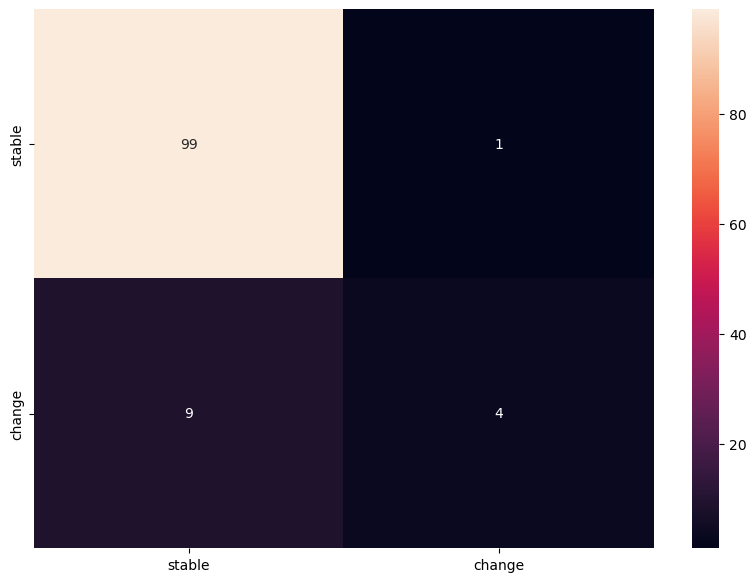

In [29]:
X_train['class'] = grid_search_clf.predict(X_train[cols_to_classify])
X_test['class'] = grid_search_clf.predict(X_test[cols_to_classify])

print('-----------------------------')
print(' Stats on train:')
print('-----------------------------')
print('Accuracy on train: ' + str(accuracy_score(y_train, X_train['class'])))
display(confusion_matrix(y_train, X_train['class']))

print('')
print('')
print('-----------------------------')
print(' Stats on test:')
print('-----------------------------')
#print('Out of Bag Error RF: ' + str(grid_search_clf.oob_score_))
print('Accuracy on test: ' + str(accuracy_score(y_test, X_test['class'], )))
cm = confusion_matrix(y_test, X_test['class'])
display(cm)

print('')
print('')
print('-----------------------------')
print(' Per class stats on test:')
print('-----------------------------')
print(classification_report(y_test, X_test['class'], target_names=['stable', 'change'], digits=4))

df_cm = pd.DataFrame(cm, index=['stable', 'change'], columns=['stable', 'change'])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

### 4.4 Feature Importance

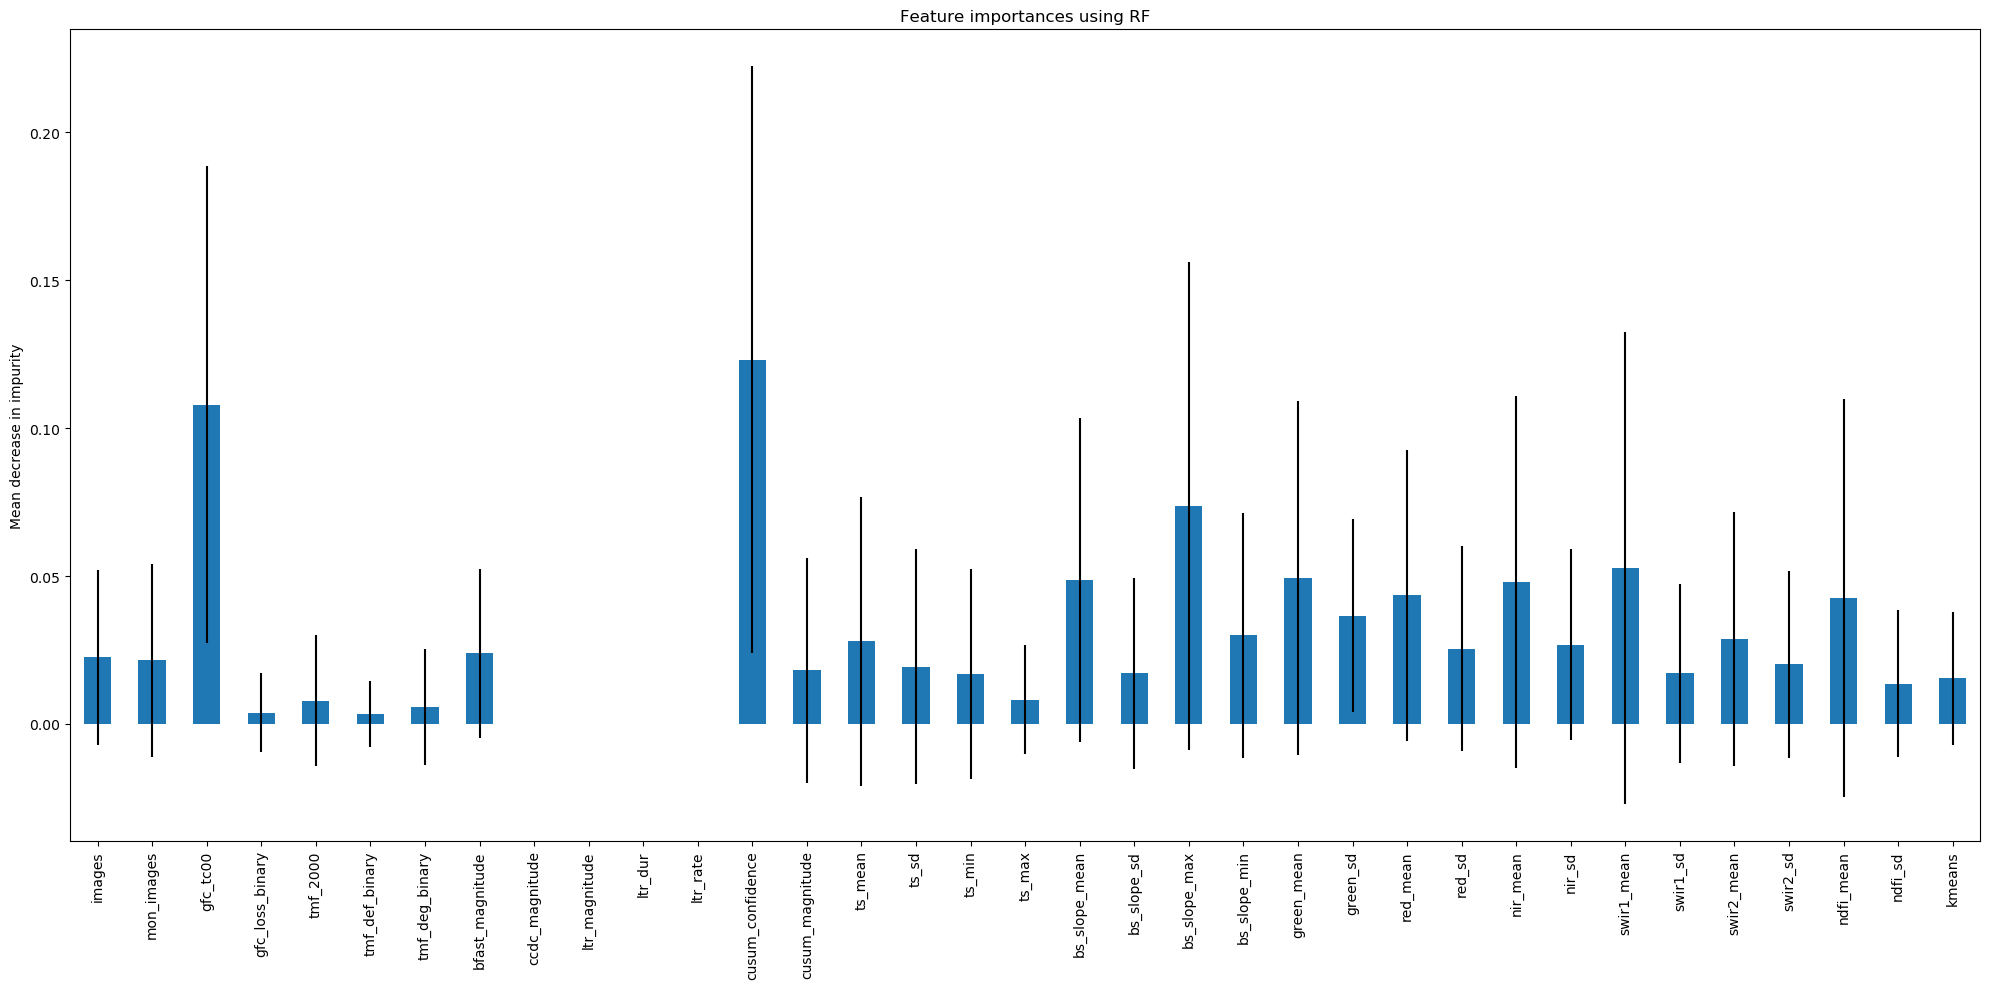

In [27]:
forest = grid_search_clf.best_estimator_
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
feature_names = [f"{i}" for i in X_train[cols_to_classify].columns]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(20,10))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using RF")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### 4.4 get threshold for not having any change

In [28]:
df_class[['prob_stable', 'prob_change']] = grid_search_clf.predict_proba(df_class[cols_to_classify][cols_to_classify])

print('Maximum probability of stable for change points')
#thshld = df_class['prob_stable'][df_class['cnc'] == 1].max()
thshld = np.percentile(df_class['prob_stable'][df_class['cnc'] == 1], 100)
print(thshld)

print('Reasonable probability of stable for change points')
#thshld = df_class['prob_stable'][df_class['cnc'] == 1].max()
thshld = np.percentile(df_class['prob_stable'][df_class['cnc'] == 1], 90)
print(thshld)

print('Number of points above thshld (considered stable)')
abv_thshld = df_class[df_class['prob_stable'] > thshld]
print(str(len(abv_thshld)) + ' out of ' + str(len(df_class)))

print('Number of actual change points left in stable')
print(len(abv_thshld[abv_thshld['cnc'] == 1]))

print(' Point Ids of interpreted change with a high probability of being stable')
display(df_class[(df_class['cnc'] == 1) & (df_class['prob_stable'] > thshld)].sort_values('prob_stable', ascending=False))

Maximum probability of stable for change points
0.992
Reasonable probability of stable for change points
0.5890666666666667
Number of points above thshld (considered stable)
503 out of 561
Number of actual change points left in stable
7
 Point Ids of interpreted change with a high probability of being stable


,PLOTID,LON,LAT,CHG_00_10,CHG_10_15,cnc_0010,cnc_1015,cnc,images,mon_images,...,nir_sd,swir1_mean,swir1_sd,swir2_mean,swir2_sd,ndfi_mean,ndfi_sd,kmeans,prob_stable,prob_change
23,67427,-7.004229,4.879998,Deforestation,Stable,1,0,1,48,46,...,632.231479,2137.088768,386.363839,988.403986,217.305028,8146.626812,1185.088710,16,0.992000,0.008000
277,124762,-6.193324,4.934256,Deforestation,Stable,1,0,1,46,44,...,723.587923,2058.464815,486.294371,1034.394444,372.637825,7633.727778,1282.893482,46,0.940000,0.060000
82,90752,-6.681922,5.910887,Deforestation,Stable,1,0,1,61,58,...,595.802187,2141.554167,445.880127,1108.613889,337.128660,7073.590000,1892.235665,11,0.891200,0.108800
125,1681,-8.299346,6.543871,Stable,Deforestation,0,1,1,66,64,...,670.418752,1925.136667,348.533378,884.414103,252.583694,8805.809231,1180.780666,45,0.852000,0.148000
26,68028,-6.993017,4.662964,Stable,Deforestation,0,1,1,38,38,...,619.055414,1986.394737,419.040490,927.057018,298.485211,8886.219298,895.716573,12,0.822667,0.177333
181,20084,-7.729443,6.525786,Deforestation,Stable,1,0,1,62,59,...,520.724634,1710.225000,273.738156,779.818056,181.889763,9089.737500,651.559742,12,0.677333,0.322667
456,48942,-7.264055,4.726266,Deforestation,Stable,1,0,1,39,36,...,590.456565,1438.797297,401.606579,678.310811,197.102503,9219.567568,971.624192,41,0.592000,0.408000


In [29]:
print(X_test.columns)
len(X_test)

Index(['images', 'mon_images', 'gfc_tc00', 'gfc_loss_binary', 'tmf_2000',
       'tmf_def_binary', 'tmf_deg_binary', 'bfast_magnitude', 'ccdc_magnitude',
       'ltr_magnitude', 'ltr_dur', 'ltr_rate', 'cusum_confidence',
       'cusum_magnitude', 'ts_mean', 'ts_sd', 'ts_min', 'ts_max',
       'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max', 'bs_slope_min',
       'green_mean', 'green_sd', 'red_mean', 'red_sd', 'nir_mean', 'nir_sd',
       'swir1_mean', 'swir1_sd', 'swir2_mean', 'swir2_sd', 'ndfi_mean',
       'ndfi_sd', 'kmeans', 'PLOTID'],
      dtype='object')


113

In [30]:
X_test[['prob_stable', 'prob_change']] = grid_search_clf.predict_proba(X_test[cols_to_classify])
X_test['cnc'] = y_test
X_test.to_csv('/home/sepal-user/sbae_point_analysis_CIV/erp_1km/validation_ign_ERP_CIV_IC_113pts.csv', index=False)

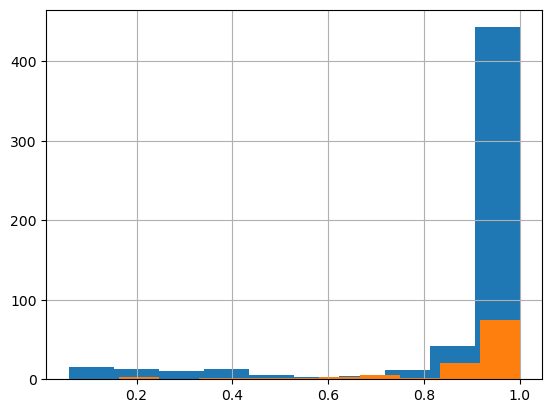

In [31]:
df_class['prob_stable'].hist()
len(df_class)

X_test['prob_stable'].hist()


In [32]:
fp_ids = df_class[(df_class['cnc'] == 1) & (df_class['prob_stable'] > thshld)]['PLOTID']

In [33]:
len(df_class)

561

### 5 Apply ensemble model to ALL points

In [34]:
ts['cnc_class'] = grid_search_clf.predict(ts[cols_to_classify])
ts[['prob_stable', 'prob_change']] = grid_search_clf.predict_proba(ts[cols_to_classify])

print(' Number of points to visually recheck based on classification result (0.5 probability)')
print(len(ts[ts['cnc_class'] == 1]))


print(' Number of points to visually recheck based on adjusted probability')
print(len(ts[ts['prob_stable'] < thshld]))

 Number of points to visually recheck based on classification result (0.5 probability)
2802
 Number of points to visually recheck based on adjusted probability
3907


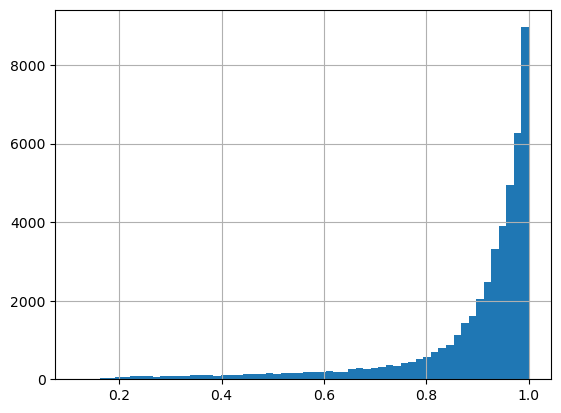

In [39]:
ts['prob_stable'].hist(bins=60)

In [35]:
print(ts.columns)

Index(['LON', 'LAT', 'PLOTID', 'aspect', 'dw_class_mode', 'dw_tree_prob__max',
       'dw_tree_prob__min', 'dw_tree_prob__stdDev', 'dw_tree_prob_mean',
       'elevation', 'esa_lc20', 'esri_lc20', 'gfc_gain', 'gfc_loss',
       'gfc_lossyear', 'gfc_tc00', 'lang_tree_height', 'point_id_x',
       'potapov_tree_height', 'slope', 'tmf_2000', 'tmf_2001', 'tmf_2002',
       'tmf_2003', 'tmf_2004', 'tmf_2005', 'tmf_2006', 'tmf_2007', 'tmf_2008',
       'tmf_2009', 'tmf_2010', 'tmf_2011', 'tmf_2012', 'tmf_2013', 'tmf_2014',
       'tmf_2015', 'tmf_defyear', 'tmf_degyear', 'tmf_main', 'tmf_sub',
       'point_idx', 'dates', 'ts', 'images', 'geometry', 'ccdc_change_date',
       'ccdc_magnitude', 'ltr_magnitude', 'ltr_dur', 'ltr_yod', 'ltr_rate',
       'ltr_end_year', 'mon_images', 'cusum_change_date', 'cusum_confidence',
       'cusum_magnitude', 'ts_mean', 'ts_sd', 'ts_min', 'ts_max',
       'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max', 'bs_slope_min',
       'point_id_y', 'bfast_magnitude

In [36]:
out_csv_file = '/home/sepal-user/sbae_point_analysis_CIV/erp_1km/bdd_erp_2000_2015_supervised_IC_ign.csv'
#tout = ts[['PLOTID','LON', 'LAT','kmeans','cnc_class', 'prob_stable', 'prob_change']]
tout = ts
tout.to_csv(out_csv_file, index=False)

### 6 Select most likely change points based on probability

In [37]:
# Number of points you can afford to analyse
nr_of_points = 3300

# select
selection = ts[['PLOTID', 'prob_change']].sort_values('prob_change', ascending=False).head(nr_of_points)
display(selection)
print('Minimum change probability included in selection: ' + str(selection['prob_change'].min()))

,PLOTID,prob_change
8322,24248,0.968000
33582,24288,0.952000
34,45725,0.950400
8425,26286,0.949333
10292,126741,0.946400
...,...,...
11628,15652,0.453333
24563,47723,0.453333
32568,123533,0.453333
10310,127379,0.453333


Minimum change probability included in selection: 0.4533333333333333


### 7 Select most grey zone points according to model

In [38]:
print(' Number of points to visually recheck based on margin of classifier') 
ts[['PLOTID', 'prob_change']][(ts['prob_change'] > 0.5) & (ts['prob_change'] < 0.55)].sort_values('prob_change', ascending=False)

 Number of points to visually recheck based on margin of classifier


,PLOTID,prob_change
23858,153525,0.549600
9401,37281,0.549333
42580,46577,0.549333
5038,52973,0.549333
12614,6667,0.549333
...,...,...
9473,38611,0.500533
7782,15633,0.500533
12112,23775,0.500533
40792,124758,0.500533
